In [ ]:
import pathlib as plb
import tarfile
import urllib.request
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
%xmode Plain
%matplotlib Inline
plt.style.use('dark_background')

In [ ]:
#downloading data and first insights
download_path = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz"
file_path = plb.Path("datasets","housing","housing.tgz")

file_path.parent.mkdir(parents=True,exist_ok = True)
urllib.request.urlretrieve(download_path, file_path)
with tarfile.open(file_path) as f:
	f.extractall(path=file_path.parent)

new_path = plb.Path(file_path.parent,"housing.csv")

housing_data = pl.read_csv(new_path)
print(housing_data.describe())

housing_data.to_pandas().hist(bins = 50, figsize = (15,20))
plt.show()

In [ ]:
#spliting data into train set and test set
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

#preparing data for method 3
housing_data = housing_data.with_columns(
    (
        pl.col('median_income') \
        .cut(breaks = [1.5,3,4.5,6], labels = ['1','2','3','4','5']) \
        .alias('median_income_cat')
    )
)
#check
#plt.hist(housing_data_cat.select(pl.col('median_income_cat')))

#method1 - fully random
def split_train_test(data, test_ratio):
 shuffled_indices = np.random.permutation(len(data))
 test_set_size = int(len(data) * test_ratio)
 test_indices = shuffled_indices[:test_set_size]
 train_indices = shuffled_indices[test_set_size:]
 return data[train_indices], data[test_indices]
train_set1, test_set1 = split_train_test(housing_data, 0.2)

#method 2 - normal sklearn
train_set2, test_set2 = train_test_split(housing_data,test_size = 0.2, random_state = 42)
train_set2, test_set2

#method 3 - stratified
splitbase = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)
for train_index, test_index in splitbase.split(housing_data, housing_data['median_income_cat']):
    strat_train_set = housing_data[train_index]
    strat_test_set = housing_data[test_index]

# final checks
#creating a summarizing DataFrame
checkdf = pl.DataFrame(
            strat_test_set['median_income_cat'].value_counts().rename({'count':'count_strat'}) \
                .join(test_set1['median_income_cat'].value_counts(), on ='median_income_cat').rename({'count':'count_random'}) \
                .join(test_set2['median_income_cat'].value_counts(), on ='median_income_cat').rename({'count':'count_overall'}) \
                .sort(pl.col('median_income_cat'))
                .cast({'median_income_cat':pl.String})
).cast({"count_strat":pl.Int64,
    "count_random":pl.Int64,
    "count_overall":pl.Int64})
#Creating a Df for checking if all sums are the same
sums = pl.DataFrame({
    'median_income_cat':'Sum', 
    'count_strat':checkdf['count_strat'].sum(), 
    'count_random':checkdf['count_random'].sum(), 
    'count_overall':checkdf['count_overall'].sum()
})
#final Df and conclusion
checkdf = pl.concat([checkdf,sums])
print(checkdf)
print('Strat and overall are the best, random is significantly skewed')
housing = strat_train_set.clone()

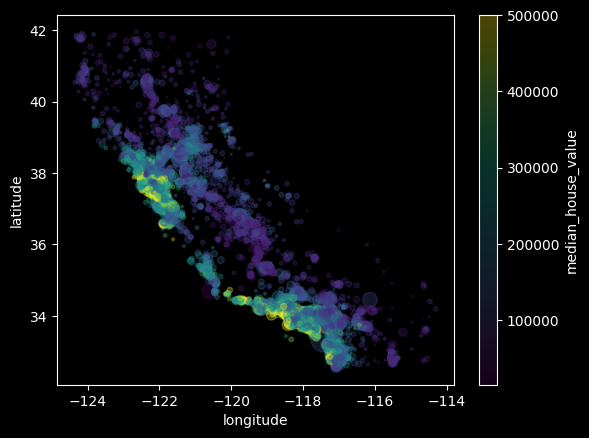

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64


In [221]:
#Gaining more insights
#Visualising house value by location and population density
plt.scatter(x = housing['longitude'], y = housing['latitude'], alpha = 0.3, s = housing['population']/100, label = 'population',
            c = housing['median_house_value'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.colorbar(label = 'median_house_value')
plt.show()

#Creating a correlation martix
corr_matrix = housing.select(pl.exclude('ocean_proximity','median_income_cat')).to_pandas().corr()
print(corr_matrix['median_house_value'].sort_values(ascending = False))